# Algorithm and Data Structures Micropresentation: Spectral Clustering
## UC Berkeley Masters in Molecular Sciences and Software Engineering
### Course: Data Structures and Algorithms - 274B

---

## Learning Objectives

By the end of this presentation, you will be able to:

1. **Implement Spectral Clustering** for real world applications

---

## Presentation Agenda

| Time | Topic | Duration |
|------|-------|----------|
| 0:00-1:00 | Introduction Overview | 1 min |
| 1:00-2:00 | Relevance to Molecular Sciences and Real World Application | 1 min |
| 2:00-4:30 | Implementation Demonstration | 2 min |
| 4:30-5:00 | Reflection | 30 sec |

## Required Imports and Setup

Let's start by importing all the libraries we'll need for this comprehensive review:

In [30]:
!pip install scanpy

In [31]:
# Core Python libraries
import numpy as np
import math

#Data manipulation
import pandas as pd
import scanpy as sc
from scipy.stats import median_abs_deviation

# Scientific computing
import scipy as sp
import scipy.sparse
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler, normalize

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ All libraries imported successfully!")
print("Ready to explore spectral clustering!")

✅ All libraries imported successfully!
Ready to explore spectral clustering!


---

# Section 1: Introduction & Course Overview (1 minutes)

## What is Spectral Clustering?
Spectral clustering is a technique that uses eigenvalues and eigenvectors to partitioned/clustered data points, represented as nodes on a graph, to find underlying patterns and relationships in complex data sets.

## Why Does it Matter?
In molecular sciences, we frequently deal with:

- **Large datasets**: Single-cell RNA-sequencing, proteomics, and mass spectrometry
- **Complex relationships**: Gene expression patterns, protein-protein interaction networks, and regulatory pathways
- **Pattern recognition**: High-throughput expression profiling

## Steps to Implement Spectral Clustering:
1. **Import a dataset of your choice**
2. **Construct a similarity matrix**
3. **Construct a Laplacian matrix** (a matrix representation of a graph that captures structural properties: Laplacian = Degree Matrix - Adjacency Matrix)
4. **Calculate the binary noram cut objective** - find an optimal classification threshold
5. **Compute eigenvalues and eigenvectors** - Extract the smallest eigenvalues and their corresponding eigenvectors
6. **Cluster using k-means in the new feature space**
7. **Vizualize the clusters**
8. **Evaluate the results**

# Data Loading and Manipulation

https://medium.com/@adam.nik/scrna-filtering-and-normalization-with-scanpy-adeae2577862
https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html

In [32]:
def load_data(filename):
  '''
  Loads in an H5 file using the ScanPy library.

  Parameters
  ----------
  filename : str
    Name of the H5 file to load in.

  Returns
  -------
  data : AnnData object
    Annotated data matrix containing single-cell RNA sequencing data.
  '''
  data = sc.read_10x_h5(filename) # load in data from H5 file using scanpy
  data.var_names_make_unique(join='___') # force names to be unique by adding __
  return data

filename = 'GSM3169075_filtered_gene_bc_matrices_h5.h5' # GEO dataset
adata = load_data(filename)


/Users/Bella/miniconda3/lib/python3.13/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [33]:
adata # annotated data matrix where cells named by barcode and genes named by gene name
      # barcode: short DNA sequence added to RNA from each cell that acts as a unique identifier so that many cells can be sequenced at once

AnnData object with n_obs × n_vars = 3372 × 58302
    var: 'gene_ids'

adata.obs: observations (cells)

adata.var: variables (genes)

adata.X: the entire matrix with shape num_observations * num_variables

In [34]:
adata.var[adata.var["gene_ids"] == "ENSG00000167286"] # search for CD3D using Ensembl gene ID (https://useast.ensembl.org/index.html)

,gene_ids
CD3D,ENSG00000167286


In [35]:
adata.var.loc['CD3D'] # search for CD3D using .loc & gene name

gene_ids    ENSG00000167286
Name: CD3D, dtype: object

In [36]:
def qc_data(data):
  '''
  Calculates quality control metrics for each cell and adds metrics in place to AnnData object.

  Parameters
  ----------
  data : AnnData object
    Annotated data matrix containing single-cell RNA sequencing data.
  '''
  # identify mitochondrial vs ribosomal genes
  # fraction of mt counts used to estimate cell health
  # all cells express mt genes at similar levels
  # any deviations may indicate cell stress
  # very high ribo gene expression can also indicate cell stress
  data.var['mt'] = adata.var_names.str.startswith("MT-") | adata.var_names.str.startswith('MT___MT-')
  data.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

  # calculate quality control metrics from each cell
  sc.pp.calculate_qc_metrics(
      data, qc_vars=["mt", "ribo"], inplace=True, percent_top=[20], log1p=True
  )

  return data

adata = qc_data(adata) # add QC metrics to adata

**QC metrics include the following** (taken from documentation: https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.calculate_qc_metrics.html )

Observation level metrics include:

total_{var_type}_by_{expr_type}
E.g. “total_genes_by_counts”. Number of genes with positive counts in a cell.

total_{expr_type}
E.g. “total_counts”. Total number of counts for a cell.

pct_{expr_type}_in_top_{n}_{var_type}
– for
n
in
percent_top
E.g. “pct_counts_in_top_50_genes”. Cumulative percentage of counts for 50 most expressed genes in a cell.

total_{expr_type}_{qc_var}
– for
qc_var
in
qc_vars
E.g. “total_counts_mito”. Total number of counts for variables in qc_vars.

pct_{expr_type}_{qc_var}
– for
qc_var
in
qc_vars
E.g. “pct_counts_mito”. Proportion of total counts for a cell which are mitochondrial.

Variable level metrics include:

total_{expr_type}
E.g. “total_counts”. Sum of counts for a gene.

n_genes_by_{expr_type}
E.g. “n_genes_by_counts”. The number of genes with at least 1 count in a cell. Calculated for all cells.

mean_{expr_type}
E.g. “mean_counts”. Mean expression over all cells.

n_cells_by_{expr_type}
E.g. “n_cells_by_counts”. Number of cells this expression is measured in.

pct_dropout_by_{expr_type}
E.g. “pct_dropout_by_counts”. Percentage of cells this feature does not appear in.




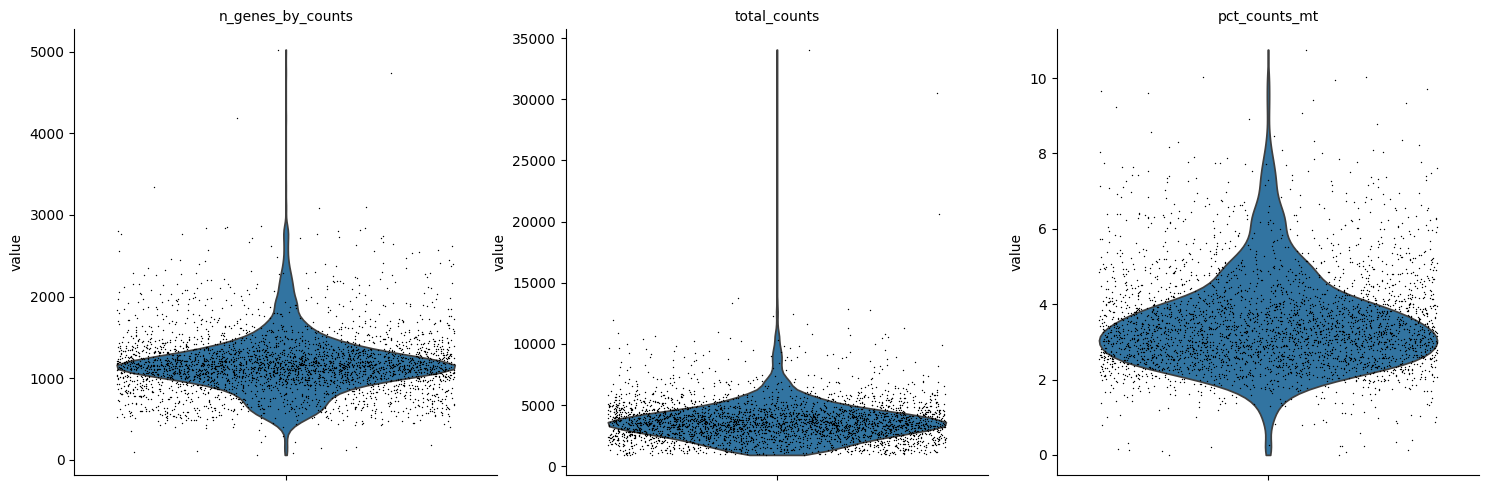

In [37]:
# Violin plots to see:
  # 1. the number of genes expressed in the count matrix
  # 2. the total counts per cell
  # 3. the percentage of counts in mt genes
# Looking at these plots will help us decide where we should define thresholds for outliers
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

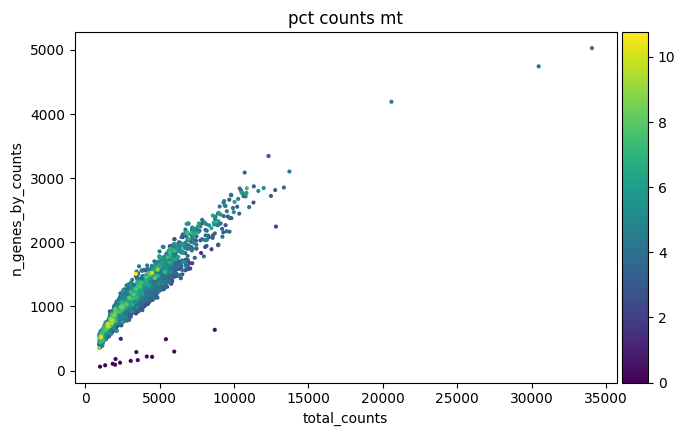

In [38]:
# Scatter plot to identify low quality cells (dead/lysed or empty droplet) and potential doublets (2+ cells captured in single droplet)
# droplet: in scRNA-seq, each cell is isolated into a droplet using a microfluidics system so that RNA from each individual cell can be sequenced from an input of many cells
# droplet = cell + lysis buffer + barcoded bead to capture mRNA
# isolation of cells into droplets isn't perfect, which is how we get doublets
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [39]:
# filter out any genes that appear in less than 10 cells (based on mean abs deviations)
def is_outlier(data, metric: str, nmads: int):
  '''
  Classifies a cell as an outlier or not based on mean absolute deviations.

  Parameters
  ----------
  data : AnnData object
    Annotated data matrix containing single-cell RNA sequencing data.

  metric : str
    Name of QC metric column to be checked for outliers.

  nmads : int
    Number of mean absolute deviations (MADs) away from median to define outliers.

  Returns
  -------
  outlier : bool Series
    True for any value in metric that is too low/too high. Can be used to filter adata.

  '''
  M = data.obs[metric]
  outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
      M > np.median(M) + nmads * median_abs_deviation(M)
  )
  return outlier

In [40]:
def filter_data(data):
  '''
  Filters dataset in place to exclude cells that are more than the desired number of MADs from the median.

  Fields to be filtered:
  log1p_total_counts : log(value + 1) transformed total number of transcript counts for each cell
  log1p_n_genes_by_counts : log(value + 1) transformed number of genes with at least 1 count in a cell
  pct_counts_mt : proportion of total counts for a cell that are mitochondrial
  pct_counts_ribo : proportion of total counts for a cell that are ribosomal

  Parameters
  ----------
  data : AnnData object
    Annotated data matrix containing single-cell RNA sequencing data.
  '''

  # Create field of adata.obs that indicates outlier status
  data.obs["outlier"] = (
    is_outlier(data, "log1p_total_counts", 5)
    | is_outlier(data, "log1p_n_genes_by_counts", 5)
    | is_outlier(data, "pct_counts_mt", 3)
    | is_outlier(data, "pct_counts_ribo", 5)
  )

  data = data[~data.obs.outlier, :]

  return data

adata = filter_data(adata) # filter adata

In [41]:
adata.X.shape # reduced total cell counts from 3372 to 2932

(2932, 58302)

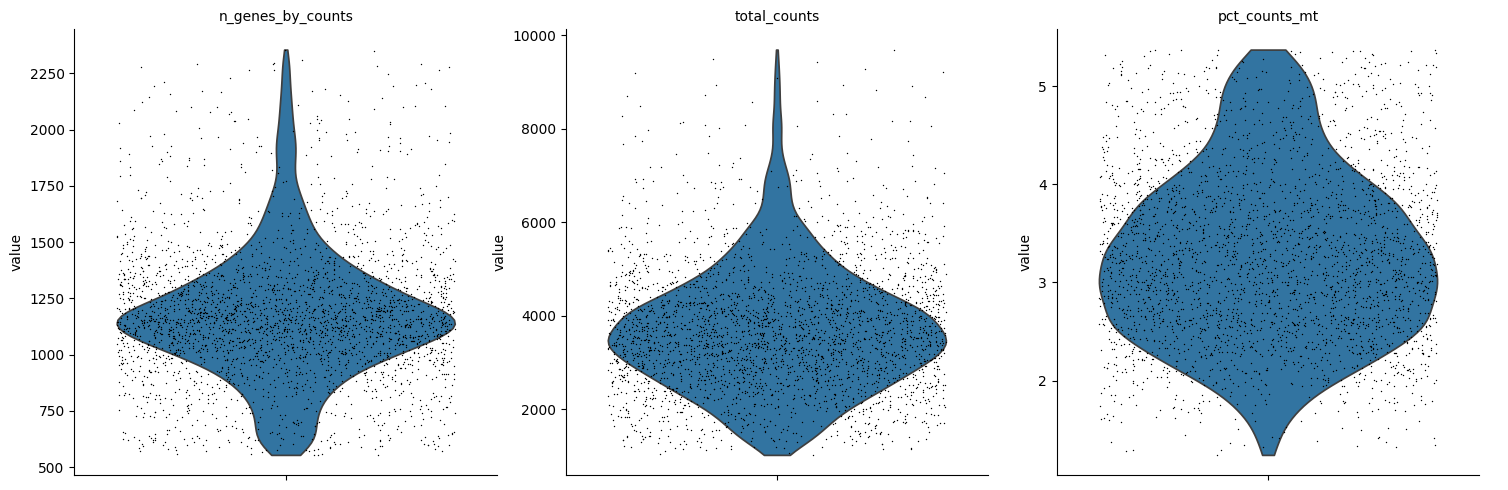

In [42]:
# Violin plots after removing outliers
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

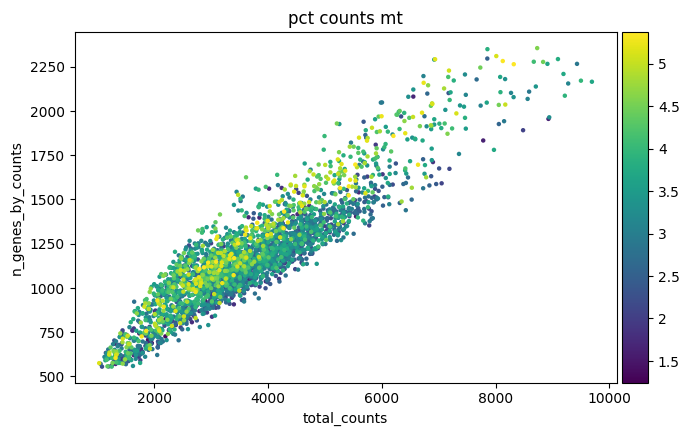

In [43]:
# scatter plot after removing outliers
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

# Data Normalization

In [44]:
def normalize_data(data):
  '''
  Normalizes each cell's summed counts to 10,000, log transforms counts, and adds count data to AnnData object in place.

  Parameters
  ----------
  data : AnnData object
    Annotated data matrix containing single-cell RNA sequencing data.
  '''
  # Normalize each cell's summed counts to 10,000 to facilitate more generalizable cell-to-cell comparisons
  sc.pp.normalize_total(data, target_sum=1e4)

  # Log transform the counts
  sc.pp.log1p(data)

  # Save current count data
  data.raw = data

  return data

adata = normalize_data(adata)

/Users/Bella/miniconda3/lib/python3.13/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [45]:
def most_variable(data):
  '''
  Finds the genes that account for the most variability in an AnnData object and filters dataset to include only those genes.

  Parameters
  ----------
  data : AnnData object
    Annotated data matrix containing single-cell RNA sequencing data.
  '''
  # Find genes that account for most variability in dataset
  sc.pp.highly_variable_genes(data) # calculates the variation in gene expression across cells and returns most variable
  data = data[:, data.var.highly_variable]

  return data

adata = most_variable(adata)
adata.X.shape # 3010 variable genes

(2932, 3010)

In [46]:
def correct_and_scale(data):
  '''
  Uses simple linear regression to correct for unwanted variation in total_counts, pct_counts_mt, and pct_counts_ribo in place.
  Scales data in place such that mean = 0 and standard deviation = 1.

  Parameters
  ----------
  data : AnnData object
    Annotated data matrix containing single-cell RNA sequencing data.
  '''
  # Remove unwanted sources of variation
  # Use SLR to correct total_counts, pct_counts_mt, pct_counts_ribo
  sc.pp.regress_out(data, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

  # Scale data to unit variance and zero mean
  sc.pp.scale(data, max_value=10)

  return data

adata = correct_and_scale(adata)

/Users/Bella/miniconda3/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:728: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [47]:
# apply PCA to reduce dimensionality
sc.tl.pca(adata, svd_solver='arpack')


# Visualize QC data

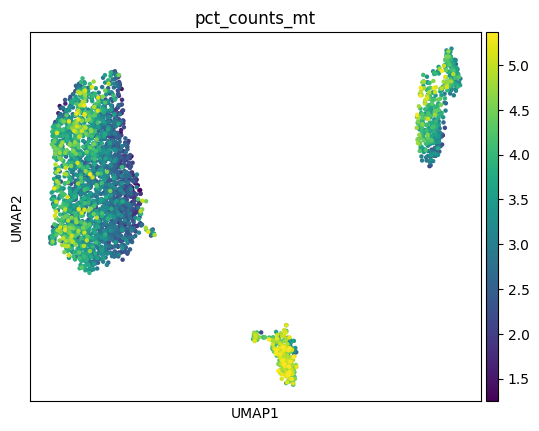

In [48]:
# UMAP2 vs UMAP1 visualization
# our first look at the QC data
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata, color='pct_counts_mt')

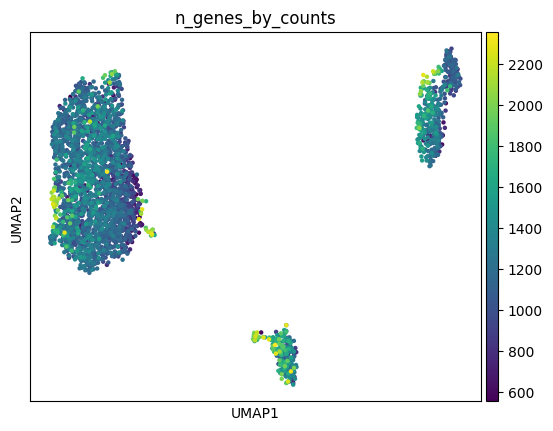

In [49]:
sc.pl.umap(adata, color='n_genes_by_counts') # good distribution of color in each cluster!

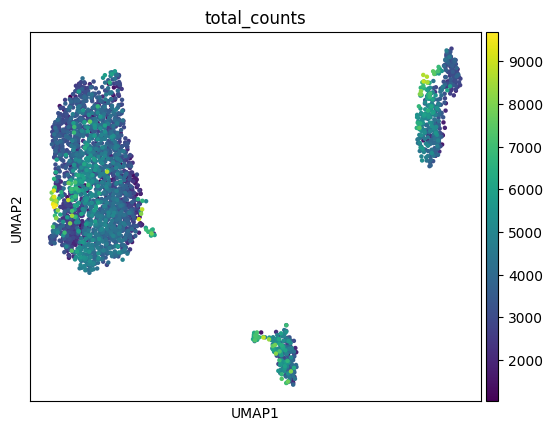

In [50]:
sc.pl.umap(adata, color='total_counts') # good distribution of color in each cluster!

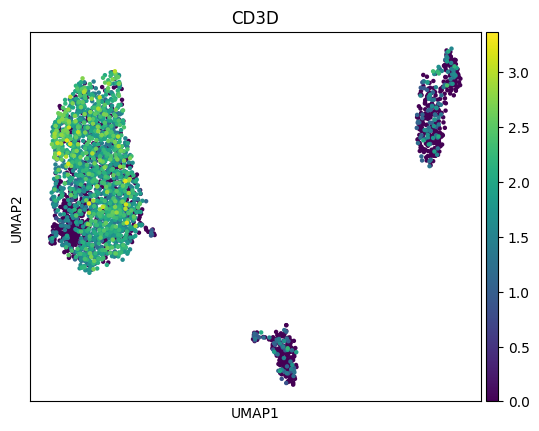

In [51]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='CD3D') # we can use this later to find the cell cluster that expresses high CD3D (to ID lymphocytes)
# could calculate mean expression of CD3D in each cluster and see which is highest

# Spectral Clustering Demonstration
### Step 1: Create a similarity matrix

We already performed dimensionality reduction, using sc.pp.pca(adata) and computed the neighbors graph in cell 19. Since the computed neighborhood graph implicitly represents a similarity matrix, we can access it in the .obsp attribute of the AnnData object - specifically the 'connectivities' matrix from the sc.pp.neigbhbors function. This contains the weighted adjacency matrix of the graph, where the values in the matrix represent the strength of the connection (and thus a similarity) in the high-dimensional gene expression space.

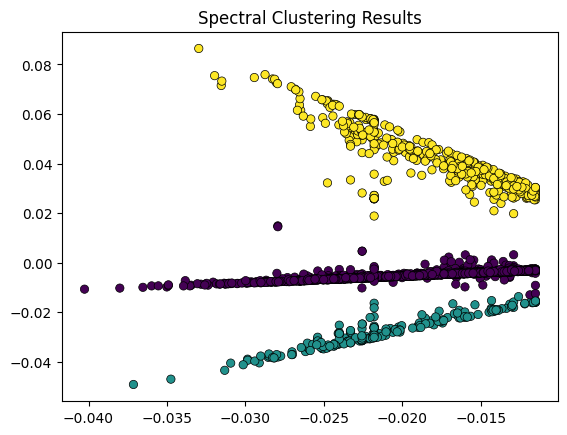

In [52]:
from scipy.sparse.linalg import eigsh
from scipy.sparse import diags
from sklearn.cluster import KMeans

def spectral_clustering(data, n_clusters):
  #1. Create the Similarity Matrix (W)

  # create k-Nearest Neighbor Graph
  sc.pp.neighbors(data, n_neighbors=15, n_pcs=30)
  # create a similarity matrix using the 'connectivities' matrix from sc.pp.neighbors
  similarity_matrix = data.obsp['connectivities']

  # 2. Normalized Laplacian matrix (L) = I - D^{-1/2} * Similarity Matrix * D^{-1/2}
  # degree matrix
  degrees = np.array(similarity_matrix.sum(axis=1)).flatten()
  #D^{-1/2} Matrix
  D_inverted_sqrt = diags(1 / np.sqrt(degrees))
  # identity matrix
  I = np.eye(similarity_matrix.shape[0])
  normalized_laplacian = I - D_inverted_sqrt @ similarity_matrix @ D_inverted_sqrt

  k = n_clusters
  # 3. Compute eigenvectors
  eigenvalues, eigenvectors = eigsh(normalized_laplacian, k=n_clusters, which='SM')
  # select the eigenvectors corresponding to the smallest k eigenvalues
  selected_eigenvectors = eigenvectors[:, :k]

  # 4. Cluster in the new feature space
  # perform k-means on the eigenvectors
  kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  kmeans.fit(selected_eigenvectors)
  spectral_labels_classic = kmeans.labels_

  # 5. Visualize the clusters
  plt.scatter(selected_eigenvectors[:, 0], selected_eigenvectors[:, 1], c=spectral_labels_classic, cmap='viridis', lw=0.5, edgecolor='k')
  plt.title('Spectral Clustering Results')
  plt.show()

  return spectral_labels_classic

spectral_labels = spectral_clustering(adata, 3)


### **Spectral Clustering Interpretation:**

The data points plotted represent all the individual cells in this data set after the initial filtering. After performing spectral clustering, which graphs the Laplacian matrix in a lower dimensional space for easier interpretation, three were visualized using the selected eigenvectors.

### **Time and Space Complexity Analysis**

Our spectral clustering has three main parts:

1. Graph construction
2. Spectral embedding
3. Clustering in the spectral space

Since we use KNN for graph construction and uses a constant number of clusters(3), the time complexity is O(n^2) where n is the number of cells. The space complexity is O(m) where m is the number of edges.

For spectral embedding, since we pick a constant number of clusters(3) and use a dense Laplacian matrix, eigen-decomposition has a time complexity of O(n^3) and a space complexity of O(n^2).


For clustering in the spectral space, since we choose a small number of clusters(3) and use only the 3 smallest eigenvectors, the time complexity is O(n) and the space complexity is O(n).

So in conclusion, our spectral clustering is dominated by the spectral embedding process and has an overall time complexity of O(n^3) and space complexity of O(n^2).


### **Advantages / Disadvantages of Spectral Clustering**
**Advantages:**
Spectral Clustering is indifferent to the number of features making it a flexible algorithm that can be applied to non-linear, complex data structures by considering the relationships and connectivity between data points.

**Limitations:**
Spectral clustering is highly sensitive to the choice of parameters used to model cell-cell similarity (kernel parameters, the number of nearest neighbors for graph construction, etc). Optimal parameters vary across different datasets, making it difficult to find a universal parameters that can be applied across molecular applications. The time and space complexity becomes the bottleneck as the naive implementation has a worst case of O(N^3) time comlexity and and O(N^2) space complexity for large dataset of N objects.

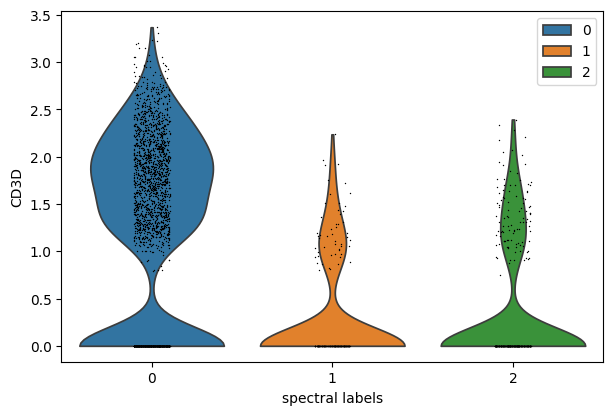

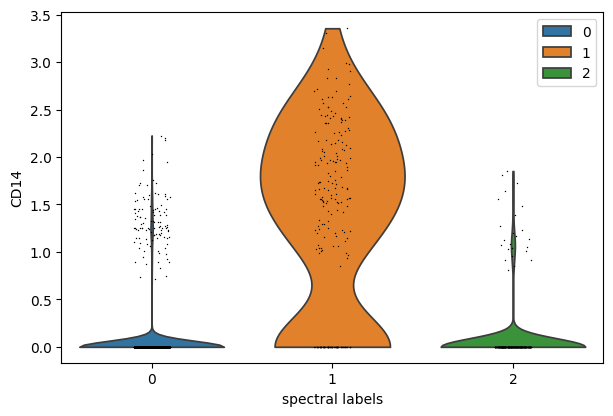

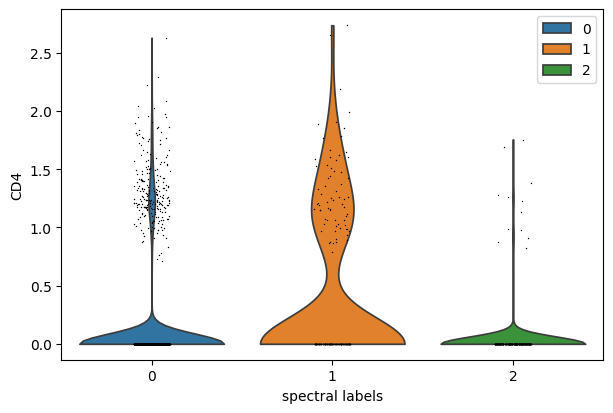

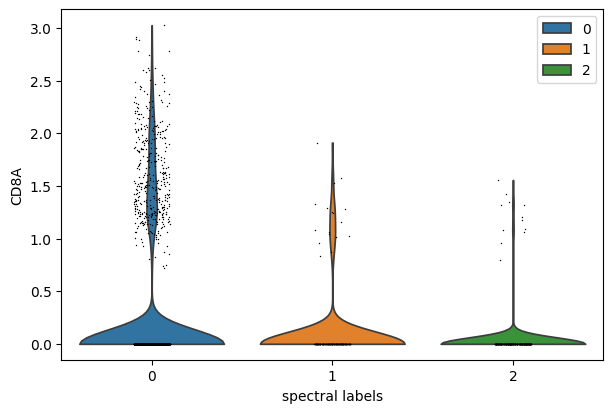

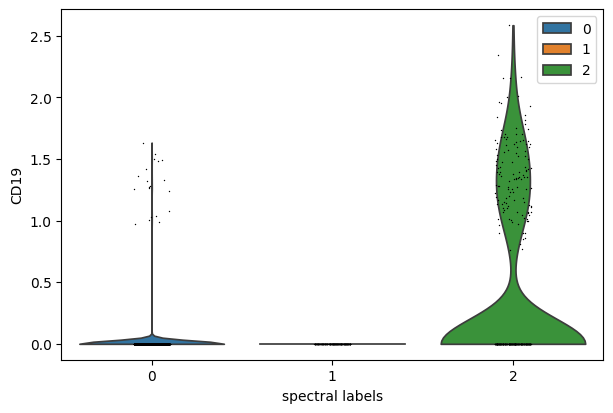

In [59]:
def plot_markers(data, spectral_labels):
  '''
  Creates violin plots to show expression of the following markers: CD3D, CD14, CD19, CD4, CD8A.

  Parameters
  ----------
  data : AnnData object
    Annotated data matrix containing single-cell RNA sequencing data.
  '''

  # add spectral labels to AnnData object
  data.obs["spectral_labels"] = spectral_labels
  data.obs["spectral_labels"] = data.obs["spectral_labels"].astype("category")

  # create violin plots
  sc.pl.violin(data, ['CD3D'], groupby='spectral_labels') # T cells express high CD3D
  plt.show()

  sc.pl.violin(data, ['CD14'], groupby='spectral_labels') # myeloid cells & monocytes express high CD14
  plt.show()

  sc.pl.violin(data, ['CD4'], groupby='spectral_labels') # CD4+ T cells express high CD4
  plt.show()

  sc.pl.violin(data, ['CD8A'], groupby='spectral_labels') # CD8+ T cells (cytotoxic) express high CD8A
  plt.show()

  sc.pl.violin(data, ['CD19'], groupby='spectral_labels') # B cells express high CD19
  plt.show()

plot_markers(adata, spectral_labels)

# Results for Spectral Clustering with 3 Clusters
**Cluster 0: highest CD3D, moderate-high CD4, high CD8A, low CD19, low CD14**

*   This cluster contains lymphocytes (CD4+ and CD8+ T cells).

**Cluster 1: low CD3D, highest CD14, high CD4, low CD8A, low CD19**
*   This cluster contains myeloid cells (most likely monocytes/macrophages because of the CD4 and CD14 co-expression).

**Cluster 2: high CD3D, highest CD8A, moderate CD4, high CD19, low CD14**
*   This cluster contains both CD8+ T cells and B cells (which are both lymphocytes).

It's important to note that there are likely a small number of other cell types in these clusters as well. We would need many clusters and would need to look at the expression of many different genes to identify them all.

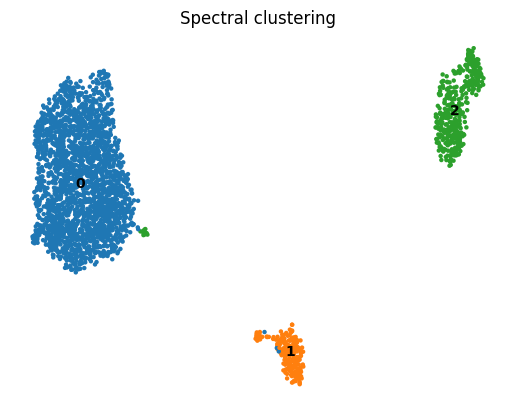

In [54]:
# Let's map our spectral clustering results back to our original cell data
sc.pl.umap(
    adata,
    color="spectral_labels",
    title="Spectral clustering",
    legend_loc="on data",
    frameon=False
)

# Alternative Implementation with Sklearn

In [55]:
from sklearn.cluster import SpectralClustering

n_clusters = 3

# Use similarity matrix
W = adata.obsp["connectivities"]

spectral_sklearn = SpectralClustering(
    n_clusters=n_clusters,
    affinity="precomputed",   # we are passing an affinity matrix directly
    assign_labels="kmeans",
    random_state=0,
    n_init=20,                # a bit more robust than the default
)

spectral_labels_sklearn = spectral_sklearn.fit_predict(W)

# Store in AnnData so we can visualize/compare easily
adata.obs["spectral_sklearn"] = spectral_labels_sklearn
adata.obs["spectral_sklearn"] = adata.obs["spectral_sklearn"].astype("category")

adata.obs["spectral_sklearn"].value_counts()

spectral_sklearn
0    2309
1     409
2     214
Name: count, dtype: int64

In [56]:
from sklearn.cluster import SpectralClustering

n_clusters = 3

# Use similarity matrix
W = adata.obsp["connectivities"]

spectral_sklearn = SpectralClustering(
    n_clusters=n_clusters,
    affinity="precomputed",   # we are passing an affinity matrix directly
    assign_labels="kmeans",
    random_state=42,
    n_init=20,                # a bit more robust than the default
)

spectral_labels_sklearn = spectral_sklearn.fit_predict(W)

# Store in AnnData so we can visualize/compare easily
adata.obs["spectral_sklearn"] = spectral_labels_sklearn
adata.obs["spectral_sklearn"] = adata.obs["spectral_sklearn"].astype("category")

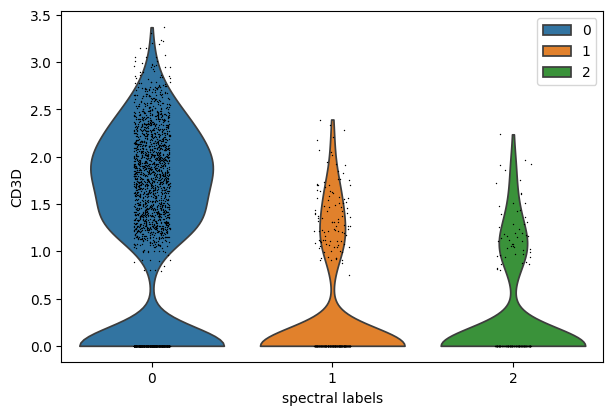

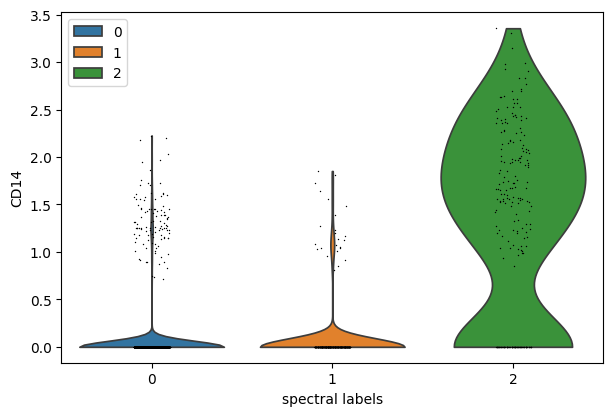

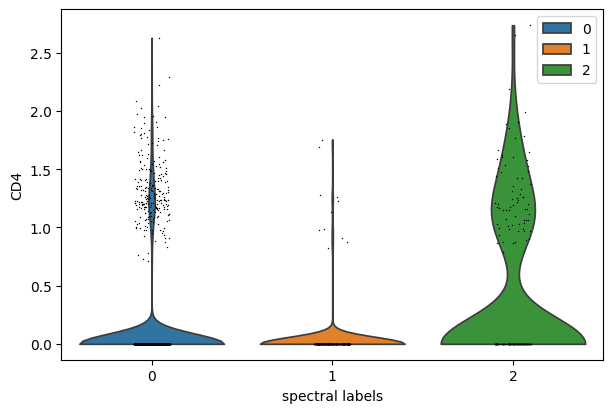

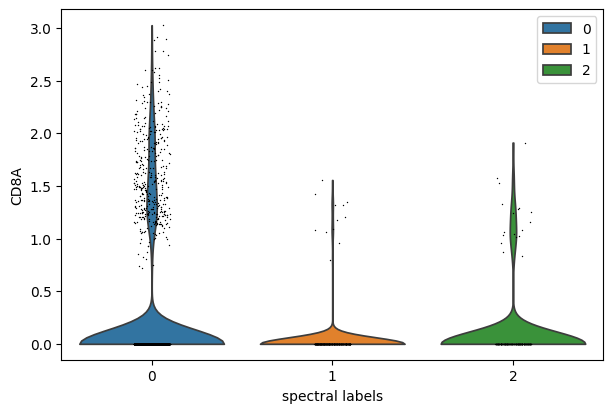

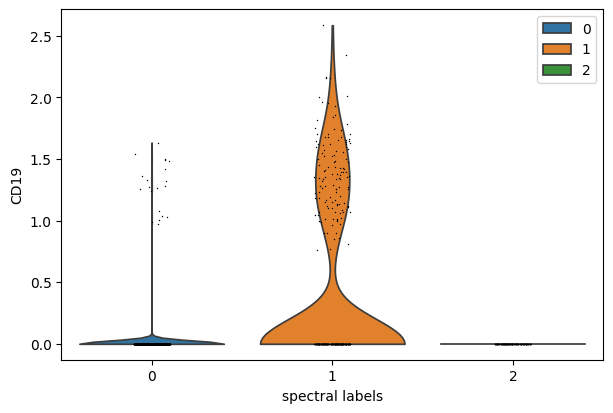

In [57]:
# create violin plots to look at expression of relevant markers
plot_markers(adata, spectral_labels_sklearn)

results are pretty similar to our implementation, other than CD14 expression in clusters 1 and 2 (lower for 2, high for 1)

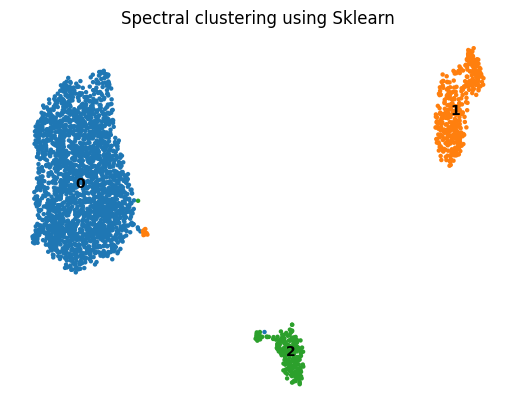

In [58]:
sc.pl.umap(
    adata,
    color="spectral_sklearn",
    title="Spectral clustering using Sklearn",
    legend_loc="on data",
    frameon=False
)

# Explanation:

To validate our spectral clustering built from scratch, we also applied the SpectralClustering implementation from scikit-learn using the same precomputed affinity matrix. The resulting clusters showed the same structure on the UMAP visualization as our custom implementation, confirming that our manual Laplacian + eigenvector implementation is consistent with the standard library implementation.

# Results for sklearn Spectral Clustering with 3 Clusters

**Cluster 0: highest CD3D, low CD4, high CD8A, low CD19, low CD14**

*   This cluster contains lymphocytes (mainly CD8+ T cells).

**Cluster 1: high CD3D, moderate CD8A, moderate CD4, moderate/low CD19, highest CD14**
*   This cluster contains both T cells and myeloid cells, possibly some B cells.

**Cluster 2: low CD3D, low CD14, highest CD4, low CD8A, low CD19**
*   This cluster contains myeloid cells (most likely monocytes/macrophages because of the CD4 and CD14 co-expression).

It's important to note that there are likely a small number of other cell types in these clusters as well. We would need many clusters and would need to look at the expression of many different genes to identify them all.